In [14]:
import numpy as np 
import pandas as pd
from fastai import *
from fastai.tabular import *
import torch
import string

# Loading the data

In [15]:
df_train = pd.read_csv("train.csv",index_col=0)
df_test = pd.read_csv("test.csv",index_col=0)

In [16]:
ord_1_map  = dict(Novice=0,Contributor=1,Expert=2,Master=3,Grandmaster=4)
ord_2_map = dict(Freezing=0,Cold=1,Warm=2,Hot=3)
ord_2_map.update({'Boiling Hot':4,'Lava Hot':5})
ord_3_lookup = {j:i for (i,j) in zip(range(len(string.ascii_lowercase)),string.ascii_lowercase)}
ord_4_lookup = {j:i for (i,j) in zip(range(len(string.ascii_lowercase)),string.ascii_uppercase)}

In [17]:
df_train.ord_1 = df_train.ord_1.map(ord_1_map)
df_train.ord_2 = df_train.ord_2.map(ord_2_map)
df_train.ord_3 = df_train.ord_3.map(ord_3_lookup)
df_train.ord_4 = df_train.ord_4.map(ord_4_lookup)

df_test.ord_1 = df_test.ord_1.map(ord_1_map)
df_test.ord_2 = df_test.ord_2.map(ord_2_map)
df_test.ord_3 = df_test.ord_3.map(ord_3_lookup)
df_test.ord_4 = df_test.ord_4.map(ord_4_lookup)

In [18]:
df_train.day.fillna(0,inplace=True)
df_train.month.fillna(0,inplace=True)

df_test.day.fillna(0,inplace=True)
df_test.month.fillna(0,inplace=True)

add_datepart(df_train,'day');
add_datepart(df_test,'day');

# add_datepart(df_train,'month');

In [19]:
dep_var = 'target'
procs = [FillMissing, Categorify]
cat_names = [i for i in df_train.columns.tolist() if i != 'target']
test = TabularList.from_df(df_test, cat_names=cat_names, procs=procs)

# Train Data Bunch
data = (TabularList.from_df(df_train, path='', cat_names=cat_names, procs=procs)
                        .split_by_rand_pct(valid_pct= 0.2, seed = 31)
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch(bs=512))

data.show_batch(rows=3)

bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,month,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,target
0.0,0.0,1.0,T,N,Blue,Circle,Lion,#na#,Bassoon,65a2ffcd1,007c05fbd,216083343,a89e1c1dc,47021df0d,1.0,3.0,2.0,12.0,2.0,AG,3.0,1970,1,1,1,3,1,False,True,False,True,False,True,0,0
0.0,0.0,1.0,F,N,Red,Square,Hamster,Russia,Bassoon,c171c8cf0,00bbcfe3e,#na#,475f992f0,9a6094970,3.0,2.0,1.0,6.0,1.0,ep,12.0,1970,1,1,1,3,1,False,True,False,True,False,True,0,1
1.0,0.0,0.0,F,N,Red,Circle,Axolotl,Costa Rica,Bassoon,6b73116a4,d3b2c54c0,8402256f6,d8bad19d0,09e219f6d,3.0,4.0,4.0,1.0,5.0,pZ,11.0,1970,1,1,1,3,1,False,True,False,True,False,True,0,1


In [20]:
df_train.target.value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [51]:
learn = tabular_learner(data, layers=[500, 300, 100],emb_drop=0.1, ps=0.1, metrics=[accuracy,AUROC()], callback_fns=[ShowGraph])

In [52]:
learn.lossfunc = CrossEntropyFlat(weight = Tensor([0.7, 0.3] * data.c).cuda())
torch.manual_seed(0)
np.random.seed(0)

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.51E-02


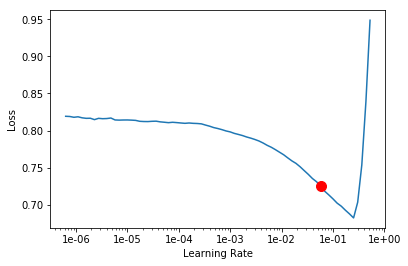

In [53]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.407746,0.407317,0.820825,0.772120,00:21
1,0.404442,0.400776,0.824617,0.779765,00:21
2,0.397980,0.401071,0.824467,0.779921,00:21


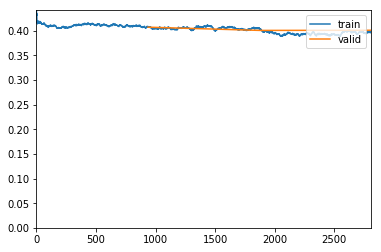

In [56]:
learn.fit_one_cycle(3,2.51E-02)

In [57]:
sub = pd.read_csv("sample_submission.csv")
preds, target = learn.get_preds(DatasetType.Test)
labels = preds.numpy()[:, 1]
sub["target"] = labels
sub.head()

,id,target
0,600000,0.129848
1,600001,0.197381
2,600002,0.126682
3,600003,0.127655
4,600004,0.145884


In [58]:
sub.to_csv("preds/fastai.csv",index=False)